## Back Test Results Binary Classification

In [1]:
import pandas as pd
from pycaret.datasets import get_data
from pycaret.classification import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('Back_Test_Result.csv')
dataset.shape

(1000, 10)

In [3]:
dataset.head()

,Candle_No,Current_Market_Fit,Current_Market,Current_Market_Stoploss,Rec1,Rec1_P,Rec2,Rec2_P,Rec3,Rec3_P
0,6588.0,68.0,Bearish,0.0,97.0,BUY,69.0,SELL,84.0,BUY
1,4779.0,100.0,Bearish,0.0,46.0,BUY,1.0,BUY,20.0,BUY
2,6286.0,97.0,Bearish,0.0,24.0,SELL,35.0,SELL,95.0,BUY
3,1205.0,60.0,Bullish,0.0,83.0,BUY,94.0,SELL,31.0,SELL
4,2823.0,100.0,Bullish,0.0,82.0,BUY,84.0,BUY,2.0,SELL


## One-Hot Encoding

In [4]:
dataset['Current_Market'] = dataset['Current_Market'].replace(['Bullish','Bearish'],[1,0])
dataset['Rec1_P'] = dataset['Rec1_P'].replace(['BUY','SELL'],[1,-1])
dataset['Rec2_P'] = dataset['Rec2_P'].replace(['BUY','SELL'],[1,-1])
dataset['Rec3_P'] = dataset['Rec3_P'].replace(['BUY','SELL'],[1,-1])

In [5]:
dataset['Rec1'] = dataset['Rec1'] * dataset['Rec1_P']
dataset['Rec2'] = dataset['Rec2'] * dataset['Rec2_P']
dataset['Rec3'] = dataset['Rec3'] * dataset['Rec3_P']

In [6]:
dataset = dataset.drop([
    'Candle_No',
    'Current_Market_Fit',
    'Current_Market_Stoploss',
#    'Rec1',
    'Rec1_P',
#    'Rec2',
    'Rec2_P',
#    'Rec3',
    'Rec3_P'
], axis=1)

In [7]:
dataset.head()

,Current_Market,Rec1,Rec2,Rec3
0,0,97.0,-69.0,84.0
1,0,46.0,1.0,20.0
2,0,-24.0,-35.0,95.0
3,1,83.0,-94.0,-31.0
4,1,82.0,84.0,-2.0


In [8]:
data = dataset.sample(frac=0.80, random_state=950).reset_index(drop=True)
data_unseen = dataset.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (800, 4)
Unseen Data For Predictions: (200, 4)


In [9]:
data_unseen.head()

,Current_Market,Rec1,Rec2,Rec3
0,0,-87.0,78.0,-98.0
1,0,-83.0,-97.0,3.0
2,1,98.0,-56.0,-41.0
3,0,-17.0,-12.0,36.0
4,0,100.0,-64.0,-68.0


# Create Unseen DataFrame

In [11]:
data_unseen.head()

,Current_Market,Rec1,Rec2,Rec3
0,0,-87.0,78.0,-98.0
1,0,-83.0,-97.0,3.0
2,1,98.0,-56.0,-41.0
3,0,-17.0,-12.0,36.0
4,0,100.0,-64.0,-68.0


In [12]:
exp_clf101 = setup(data = data, target = 'Current_Market', session_id=123, silent=True) 

,Description,Value
0,session_id,123
1,Target,Current_Market
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(800, 4)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [13]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5313,0.5328,0.4947,0.5141,0.5028,0.0603,0.0606,0.0120
dt,Decision Tree Classifier,0.5242,0.5252,0.5469,0.5044,0.5229,0.0500,0.0506,0.0050
rf,Random Forest Classifier,0.5224,0.5311,0.4947,0.5053,0.4973,0.0430,0.0438,0.0440
nb,Naive Bayes,0.5188,0.4958,0.3125,0.5146,0.3833,0.0235,0.0303,0.1130
lightgbm,Light Gradient Boosting Machine,0.5152,0.5112,0.4984,0.4917,0.4930,0.0291,0.0299,0.0090
lr,Logistic Regression,0.5135,0.5077,0.3127,0.5068,0.3815,0.0132,0.0193,0.1980
ridge,Ridge Classifier,0.5135,0.0000,0.3127,0.5068,0.3815,0.0132,0.0193,0.0040
lda,Linear Discriminant Analysis,0.5135,0.5077,0.3127,0.5068,0.3815,0.0132,0.0193,0.0040
svm,SVM - Linear Kernel,0.5099,0.0000,0.4984,0.4946,0.4950,0.0193,0.0193,0.0040
et,Extra Trees Classifier,0.4956,0.5029,0.4389,0.4754,0.4529,-0.0128,-0.0123,0.0400


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

stop

In [14]:
MODEL = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5714,0.4955,0.6296,0.5484,0.5862,0.1461,0.1476
1,0.6071,0.6335,0.7037,0.5758,0.6333,0.2193,0.2244
2,0.5000,0.5236,0.4815,0.4815,0.4815,-0.0013,-0.0013
3,0.4464,0.4266,0.4074,0.4231,0.4151,-0.1100,-0.1100
4,0.4464,0.4074,0.3704,0.4167,0.3922,-0.1128,-0.1135
5,0.5893,0.6041,0.4815,0.5909,0.5306,0.1722,0.1751
6,0.4643,0.4649,0.4074,0.4400,0.4231,-0.0755,-0.0757
7,0.6250,0.6488,0.6296,0.6071,0.6182,0.2500,0.2502
8,0.3750,0.3436,0.2963,0.3333,0.3137,-0.2564,-0.2579
9,0.5273,0.5637,0.5769,0.5000,0.5357,0.0592,0.0598


In [15]:
TUNED_MODEL = tune_model(MODEL)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6250,0.6692,0.7037,0.5938,0.6441,0.2538,0.2579
1,0.6429,0.6462,0.6296,0.6296,0.6296,0.2848,0.2848
2,0.5714,0.5619,0.5185,0.5600,0.5385,0.1396,0.1399
3,0.5357,0.4879,0.5926,0.5161,0.5517,0.0750,0.0757
4,0.5179,0.5453,0.4074,0.5000,0.4490,0.0283,0.0287
5,0.4643,0.5109,0.4074,0.4400,0.4231,-0.0755,-0.0757
6,0.5536,0.4777,0.5556,0.5357,0.5455,0.1071,0.1072
7,0.4464,0.4879,0.4444,0.4286,0.4364,-0.1071,-0.1072
8,0.3750,0.2989,0.3333,0.3462,0.3396,-0.2532,-0.2534
9,0.5636,0.5438,0.5769,0.5357,0.5556,0.1281,0.1285


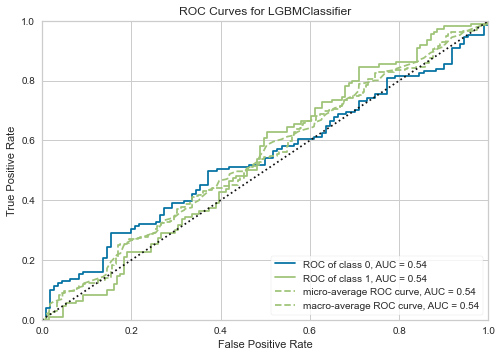

In [16]:
plot_model(TUNED_MODEL, plot = 'auc')

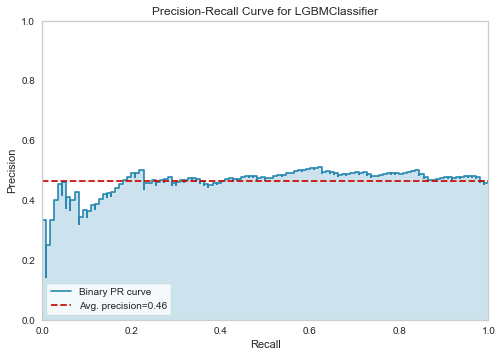

In [17]:
plot_model(TUNED_MODEL, plot = 'pr')

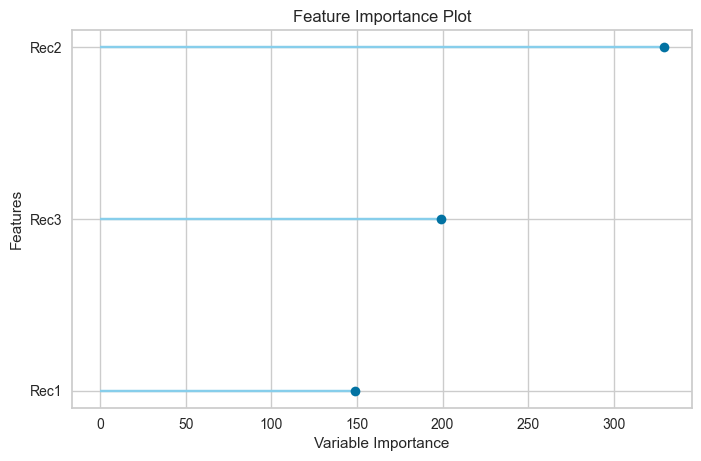

In [18]:
plot_model(TUNED_MODEL, plot='feature')

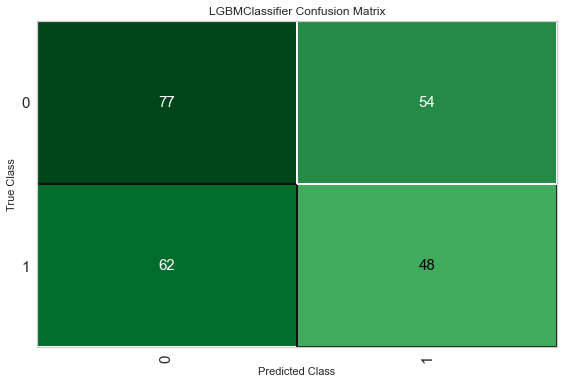

In [19]:
plot_model(TUNED_MODEL, plot = 'confusion_matrix')

In [20]:
predict_model(TUNED_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.5187,0.5377,0.4364,0.4706,0.4528,0.0243,0.0243


In [21]:
FINAL_MODEL = finalize_model(TUNED_MODEL)

In [22]:
print(FINAL_MODEL)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [23]:
predict_model(FINAL_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9502,0.9926,0.9364,0.9537,0.9450,0.8995,0.8996


In [24]:
unseen_predictions = predict_model(FINAL_MODEL, data=data_unseen)
unseen_predictions.head()

,Current_Market,Rec1,Rec2,Rec3,Label,Score
0,0,-87.0,78.0,-98.0,0,0.7909
1,0,-83.0,-97.0,3.0,0,0.7689
2,1,98.0,-56.0,-41.0,1,0.9380
3,0,-17.0,-12.0,36.0,0,0.7999
4,0,100.0,-64.0,-68.0,0,0.6300


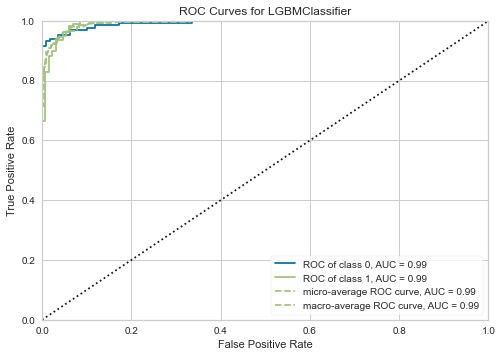

In [25]:
plot_model(FINAL_MODEL, plot = 'auc')

In [26]:
save_model(FINAL_MODEL,'FINAL_LIGHTGBM_20Nov2021_USDCAD')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Current_Market',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nume...
                                 colsample_bytree=1.0, feature_fraction=0.5,
                                 importance_type='split', learning_rate=0.4,
                                 max_depth=-1, min_child_samples=6,
             

In [27]:
SAVED_FINAL_MODEL = load_model('FINAL_LIGHTGBM_20Nov2021_USDCAD')

Transformation Pipeline and Model Successfully Loaded


In [28]:
new_prediction = predict_model(SAVED_FINAL_MODEL, data=data_unseen)

In [29]:
new_prediction.head(20)

,Current_Market,Rec1,Rec2,Rec3,Label,Score
0,0,-87.0,78.0,-98.0,0,0.7909
1,0,-83.0,-97.0,3.0,0,0.7689
2,1,98.0,-56.0,-41.0,1,0.9380
3,0,-17.0,-12.0,36.0,0,0.7999
4,0,100.0,-64.0,-68.0,0,0.6300
5,0,-94.0,-99.0,-37.0,1,0.8752
6,0,50.0,99.0,90.0,0,0.9393
7,0,95.0,30.0,-94.0,0,0.8709
8,0,-85.0,81.0,99.0,0,0.6332
9,1,-58.0,0.0,17.0,1,0.6116
